In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
tweet_df = pd.read_csv('train.csv')

In [3]:
tweet_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
# printing random tweets 
print(tweet_df['tweet'].iloc[0],"\n")
print(tweet_df['tweet'].iloc[1],"\n")
print(tweet_df['tweet'].iloc[2],"\n")
print(tweet_df['tweet'].iloc[3],"\n")
print(tweet_df['tweet'].iloc[4],"\n")

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run 

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked 

  bihday your majesty 

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦   

 factsguide: society now    #motivation 



In [6]:
#creating a function to process the data
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [7]:
tweet_df.tweet = tweet_df['tweet'].apply(data_processing)

In [8]:
tweet_df = tweet_df.drop_duplicates('tweet')

In [9]:
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data]
    return data

In [10]:
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: lemmatizing(x))

In [11]:
# printing the data to see the effect of preprocessing
print(tweet_df['tweet'].iloc[0],"\n")
print(tweet_df['tweet'].iloc[1],"\n")
print(tweet_df['tweet'].iloc[2],"\n")
print(tweet_df['tweet'].iloc[3],"\n")
print(tweet_df['tweet'].iloc[4],"\n")

user father dysfunctional selfish drags kids dysfunction run 

user user thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked 

bihday majesty 

model love u take u time ur 

factsguide society motivation 



In [12]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29345 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29345 non-null  int64 
 1   label   29345 non-null  int64 
 2   tweet   29345 non-null  object
dtypes: int64(2), object(1)
memory usage: 917.0+ KB


In [13]:
tweet_df['label'].value_counts()

0    27352
1     1993
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

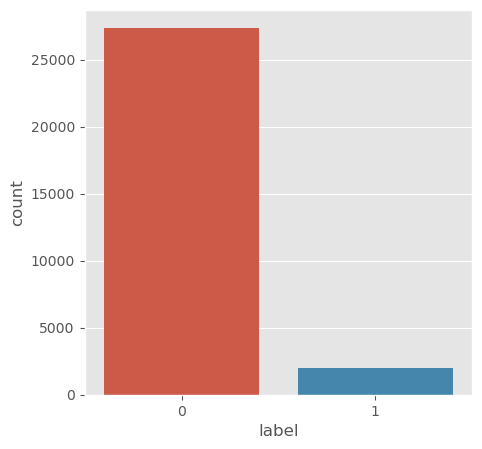

In [14]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = tweet_df)

Text(0.5, 1.0, 'Distribution of sentiments')

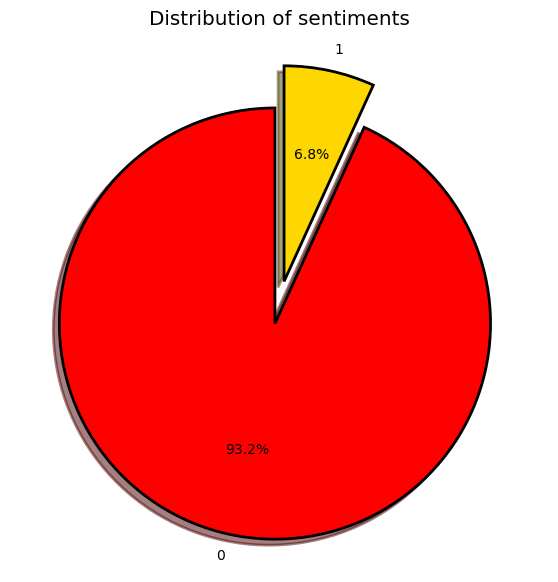

In [15]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = tweet_df['label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [16]:
non_hate_tweets = tweet_df[tweet_df.label == 0]
non_hate_tweets.head()

,id,label,tweet
0,1,0,user father dysfunctional selfish drags kids d...
1,2,0,user user thanks lyft credit cant use cause do...
2,3,0,bihday majesty
3,4,0,model love u take u time ur
4,5,0,factsguide society motivation


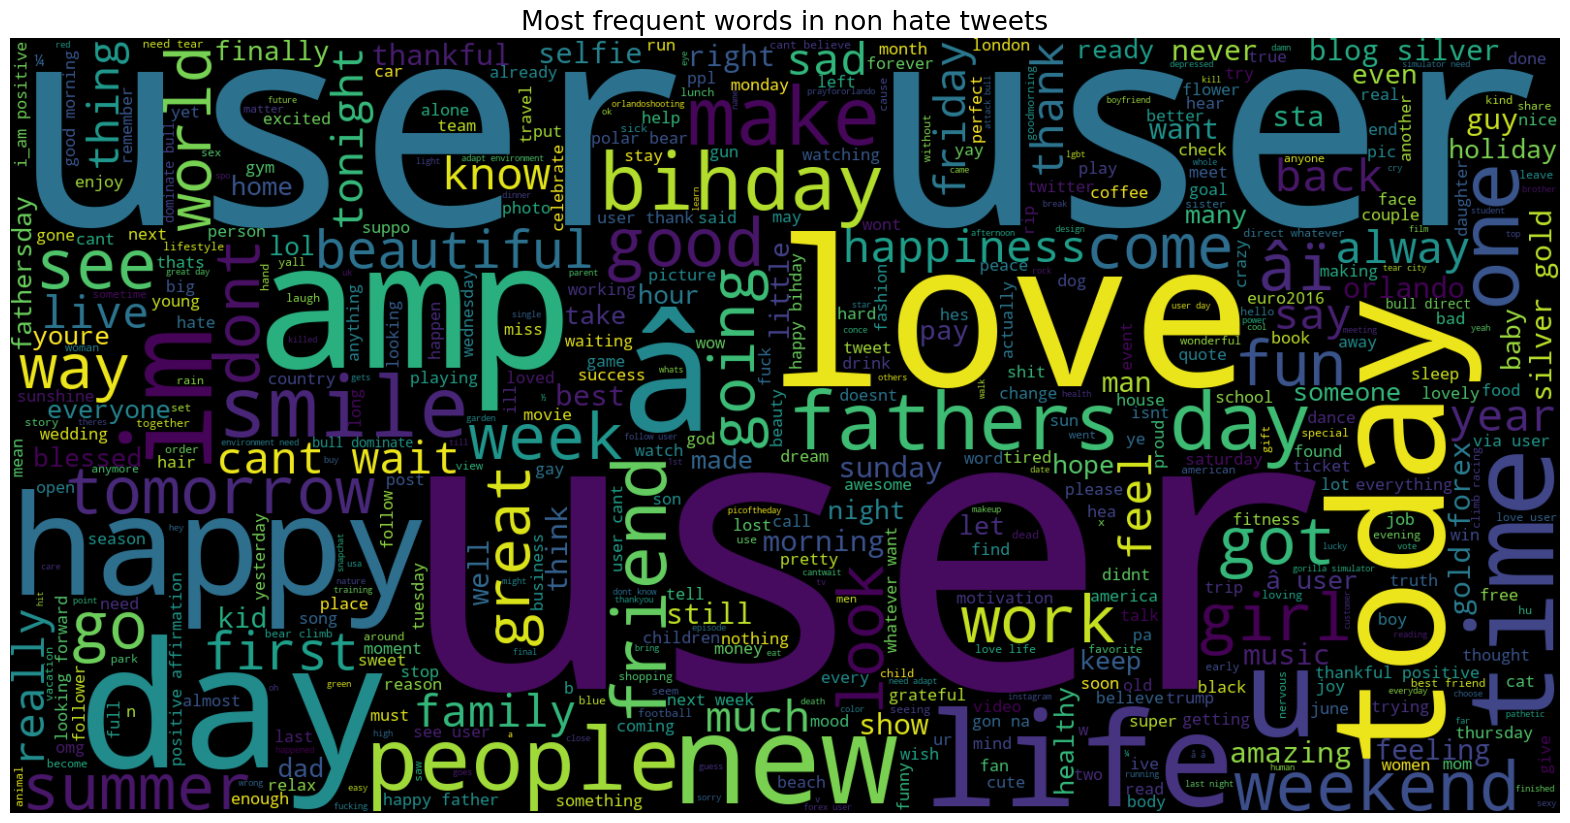

In [17]:
text = ' '.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non hate tweets', fontsize = 19)
plt.show()

In [18]:
neg_tweets = tweet_df[tweet_df.label == 1]
neg_tweets.head()

,id,label,tweet
13,14,1,user cnn calls michigan middle school build wa...
14,15,1,comment australia opkillingbay seashepherd hel...
17,18,1,retweet agree
23,24,1,user user lumpy says prove lumpy
34,35,1,unbelievable 21st century wed need something l...


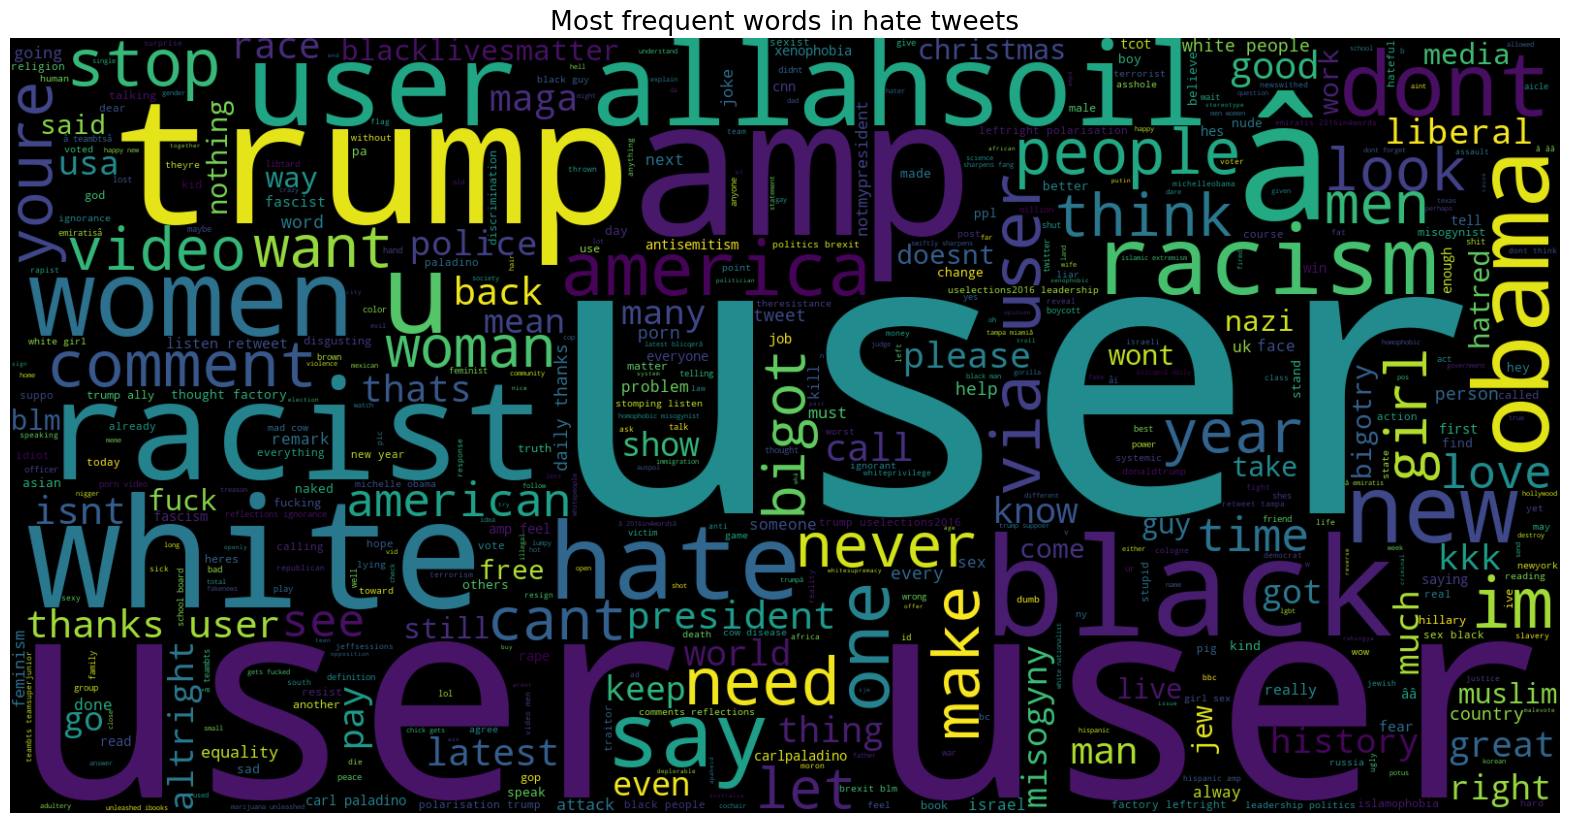

In [19]:
text = ' '.join([word for word in neg_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in hate tweets', fontsize = 19)
plt.show()

In [20]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(tweet_df['tweet'])

In [21]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 208579

First 20 features: 
['0000001', '0000001 polluting', '00027', '00027 photooftheday', '001', '0035', '00h30', '01', '01 4995', '01 7900', '01 blog', '01 croatia', '01 may', '01 shopalyssas', '0115', '0115 8599968', '0161', '0161 manny', '019', '019 previous']


C:\Users\Ekaansh Khosla\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(tweet_df['tweet'])

In [23]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 380305

First 20 features: 
['0000001', '0000001 polluting', '0000001 polluting niger', '00027', '00027 photooftheday', '00027 photooftheday music', '001', '0035', '00h30', '01', '01 4995', '01 4995 rustic', '01 7900', '01 7900 shopalyssas', '01 blog', '01 blog silver', '01 croatia', '01 croatia happy', '01 may', '01 may actual']


In [24]:
X = tweet_df['tweet']
Y = tweet_df['label']
X = vect.transform(X)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (23476, 380305)
Size of y_train: (23476,)
Size of x_test:  (5869, 380305)
Size of y_test:  (5869,)


In [27]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_predict, y_test)
print("Test accuarcy: {:.2f}%".format(logreg_acc*100))

Test accuarcy: 93.17%


In [28]:
print(confusion_matrix(y_test, logreg_predict))
print("\n")
print(classification_report(y_test, logreg_predict))

[[5458    0]
 [ 401   10]]


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5458
           1       1.00      0.02      0.05       411

    accuracy                           0.93      5869
   macro avg       0.97      0.51      0.51      5869
weighted avg       0.94      0.93      0.90      5869



In [29]:
tweet_df.shape

(29345, 3)

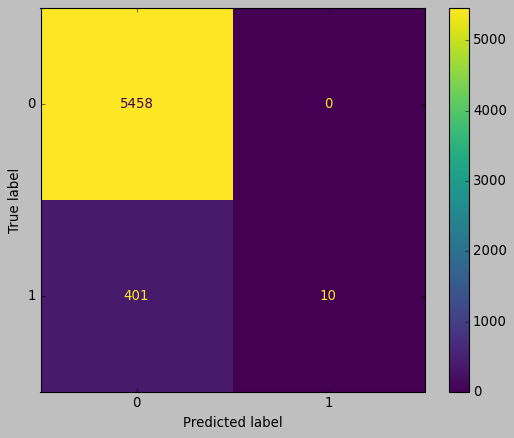

In [30]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()